In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import os

import phenom

import tempfile
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [120]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [2]:
import wispy.lalutils
import wispy.model_utils

In [7]:
import lalsimulation as lalsim

# single case

In [66]:
p = wispy.lalutils.gen_td_wf_params(m1=200, S1x=0.99, approximant=lalsim.SEOBNRv4P, f_min=5, distance=1e6)
times, amp, phase = wispy.lalutils.gen_td_wf(p)

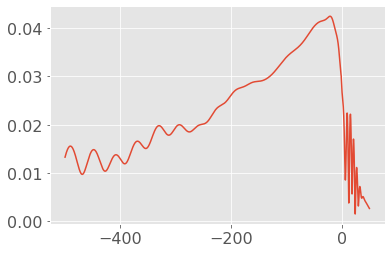

In [67]:
plt.figure()
plt.plot(times, amp)

In [68]:
def build_model(input_shape, output_shape, resnet=True):
    input_layer = tf.keras.Input(shape=(input_shape,))
    
    x = tf.keras.layers.Dense(2, activation='relu')(input_layer)
#     x = tf.keras.layers.Dense(128, activation='relu')(x)
#     x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(output_shape, activation='linear')(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = tf.nn.relu(x)
    
    if resnet:
        addition = tf.keras.layers.Add()([input_layer, x])
        x = tf.keras.layers.ReLU()(addition)
        x = tf.keras.layers.Dense(2, activation='relu')(x)
#         x = tf.keras.layers.Dense(128, activation='relu')(x)
        output_layer = tf.keras.layers.Dense(output_shape, activation='linear')(x)
#         x = tf.keras.layers.ReLU()(addition)
#         output_layer = tf.keras.layers.Dense(output_shape, activation='linear')(addition)
    else:
        x = tf.keras.layers.Dense(2, activation='relu')(x)
#         x = tf.keras.layers.Dense(128, activation='relu')(x)
        output_layer = tf.keras.layers.Dense(output_shape, activation='linear')(x)
    
    model = tf.keras.Model(input_layer, output_layer)
    
    return model

In [69]:
x = np.array([[100]])

In [70]:
x.shape

(1, 1)

In [71]:
y = amp[np.newaxis, :]

In [72]:
y.shape

(1, 2774)

In [73]:
%%time

model_nores = build_model(input_shape=x.shape[1], output_shape=y.shape[1], resnet=False)

lr = 1e-2

if lr is None:
    boundaries = [1e4, 2e4]
    values = [1e-3, 1e-3/2, 1e-4]
    learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    opt = tf.keras.optimizers.Adam(learning_rate_fn)
else:
    optimizer = tf.keras.optimizers.Adam(lr)
    
model_nores.compile(loss='mse', optimizer=optimizer)

callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

history_nores = model_nores.fit(x, y, epochs=500, verbose=0, callbacks=callbacks, batch_size=1)

Training:   0%|           0/500 ETA: ?s,  ?epochs/s

CPU times: user 1.86 s, sys: 248 ms, total: 2.11 s
Wall time: 2.41 s


In [74]:
%%time

model_res = build_model(input_shape=x.shape[1], output_shape=y.shape[1], resnet=True)


lr = 1e-2

if lr is None:
    boundaries = [1e4, 2e4]
    values = [1e-3, 1e-3/2, 1e-4]
    learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    opt = tf.keras.optimizers.Adam(learning_rate_fn)
else:
    optimizer = tf.keras.optimizers.Adam(lr)

model_res.compile(loss='mse', optimizer=optimizer)

callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

history_res = model_res.fit(x, y, epochs=500, verbose=0, callbacks=callbacks, batch_size=1)

Training:   0%|           0/500 ETA: ?s,  ?epochs/s

CPU times: user 1.88 s, sys: 255 ms, total: 2.13 s
Wall time: 2.66 s


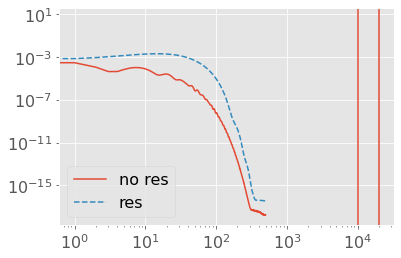

In [75]:
plt.figure()
plt.plot(history_nores.history['loss'], label='no res')
plt.plot(history_res.history['loss'], label='res', ls='--')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.axvline(1e4)
plt.axvline(2e4)

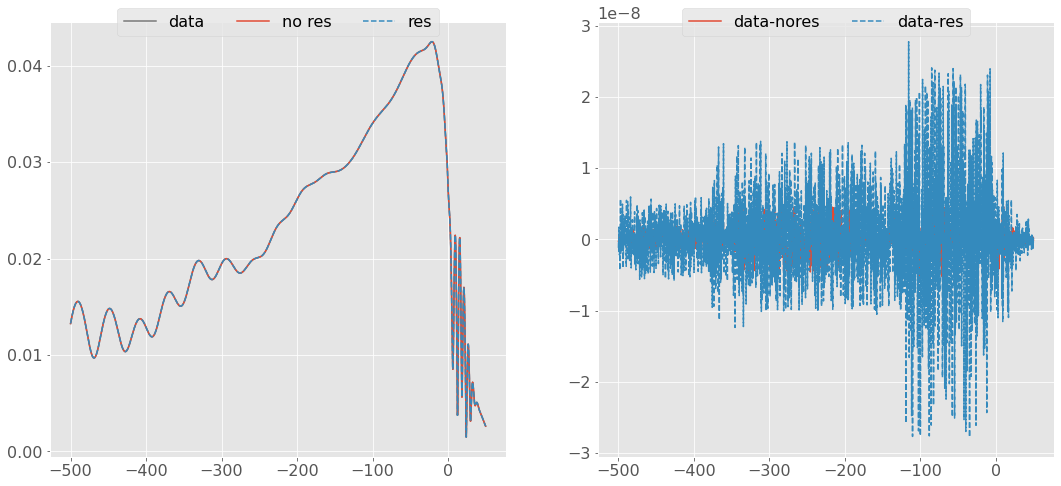

In [78]:
yhat_nores = model_nores.predict(x)[0]
yhat_res = model_res.predict(x)[0]
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(times, y[0], label='data', c='C3')
plt.plot(times, yhat_nores, label='no res', c='C0')
plt.plot(times, yhat_res, label='res', c='C1', ls='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)
# plt.xlim(-100, 100)

plt.subplot(1, 2, 2)
plt.plot(times, y[0]-yhat_nores, label='data-nores', c='C0')
plt.plot(times, y[0]-yhat_res, label='data-res', c='C1', ls='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
# plt.ylim(-0.01,0.01)

# multiple cases

In [597]:
m1s = np.linspace(100, 101, 2)[:,np.newaxis]

ps = [wispy.lalutils.gen_td_wf_params(m1=m1[0], S1x=0.99, approximant=lalsim.SEOBNRv4P, f_min=5, distance=1e6) for m1 in m1s]
times = []
amp = []
phase = []

for p in ps:
    _times, _amp, _phase = wispy.lalutils.gen_td_wf(p, t_max=40)
    times.append(_times)
    amp.append(_amp)
    phase.append(_phase)


In [598]:
# find common times and interpolate data onto common time grid
dt_M = 0.5
common_tmin = np.max(list(map(np.min, times)))
common_tmax = np.min(list(map(np.max, times)))

print(f"common_tmin = {common_tmin}")
print(f"common_tmax = {common_tmax}")

common_times = np.arange(common_tmin, common_tmax, dt_M)

ntimes = len(common_times)
print(f"ntimes = {ntimes}")

amps = np.zeros(shape=(len(m1s), ntimes))
phases = np.zeros(shape=(len(m1s), ntimes))

for i in range(len(m1s)):
    amps[i] = IUS(times[i], amp[i])(common_times)
    phases[i] = IUS(times[i], phase[i])(common_times)

common_tmin = -499.6751074055024
common_tmax = 39.68815803178109
ntimes = 1079


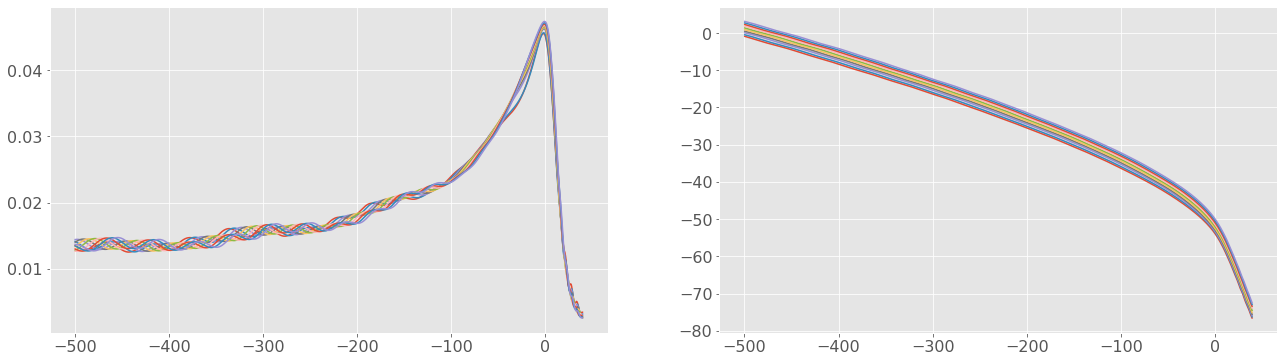

In [599]:
plt.figure(figsize=(22, 6))
plt.subplot(1, 2, 1)
for y in amps:
    plt.plot(common_times, y)
    
# plt.xlim(-100, 40)


plt.subplot(1, 2, 2)
for y in phases:
    plt.plot(common_times, y)

In [600]:
def build_model(input_shape, output_shape, resnet=True):
    input_layer = tf.keras.Input(shape=(input_shape,))
    
    x = tf.keras.layers.Dense(16, activation='relu')(input_layer)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(output_shape, activation='linear')(x)

    
    if resnet:
#         x = tf.keras.layers.BatchNormalization()(x)
        addition = tf.keras.layers.Add()([input_layer, x])
        x = tf.keras.layers.ReLU()(addition)
#         x = tf.keras.layers.Dense(2, activation='relu')(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        output_layer = tf.keras.layers.Dense(output_shape, activation='linear')(x)
#         x = tf.keras.layers.ReLU()(addition)
#         output_layer = tf.keras.layers.Dense(output_shape, activation='linear')(addition)
    else:
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        output_layer = tf.keras.layers.Dense(output_shape, activation='linear')(x)
    
    model = tf.keras.Model(input_layer, output_layer)
    
    return model

In [601]:
x = m1s
y = amps/amps.max()
# y = phases

In [602]:
x.shape

(10, 1)

In [603]:
y.shape

(10, 1079)

In [604]:
%%time

model_nores = build_model(input_shape=x.shape[1], output_shape=y.shape[1], resnet=False)

lr = 1e-3
# lr = None

if lr is None:
    boundaries = [1e3, 2e3]
    values = [1e-3, 1e-3/2, 1e-4]
    learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    opt = tf.keras.optimizers.Adam(learning_rate_fn)
else:
    optimizer = tf.keras.optimizers.Adam(lr)
    
model_nores.compile(loss='mse', optimizer=optimizer)

callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

history_nores = model_nores.fit(x, y, epochs=10000, verbose=0, callbacks=callbacks, batch_size=10)

Training:   0%|           0/10000 ETA: ?s,  ?epochs/s

CPU times: user 46.6 s, sys: 8.33 s, total: 54.9 s
Wall time: 21.1 s


In [397]:
%%time

model_res = build_model(input_shape=x.shape[1], output_shape=y.shape[1], resnet=True)


lr = 1e-3
# lr = None

if lr is None:
    boundaries = [1e3, 2e3]
    values = [1e-3, 1e-3/2, 1e-4]
    learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    opt = tf.keras.optimizers.Adam(learning_rate_fn)
else:
    optimizer = tf.keras.optimizers.Adam(lr)

model_res.compile(loss='mse', optimizer=optimizer)

callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

history_res = model_res.fit(x, y, epochs=10000, verbose=0, callbacks=callbacks, batch_size=2)

Training:   0%|           0/10000 ETA: ?s,  ?epochs/s

CPU times: user 44.6 s, sys: 9.55 s, total: 54.1 s
Wall time: 23.1 s


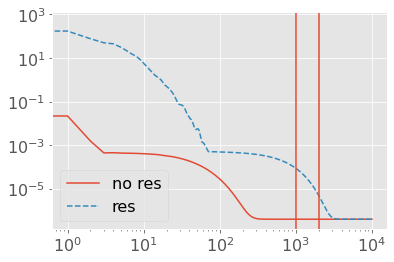

In [398]:
plt.figure()
plt.plot(history_nores.history['loss'], label='no res')
plt.plot(history_res.history['loss'], label='res', ls='--')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.axvline(1e3)
plt.axvline(2e3)

2021-03-31 14:30:05,424 - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x17d3c3c20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


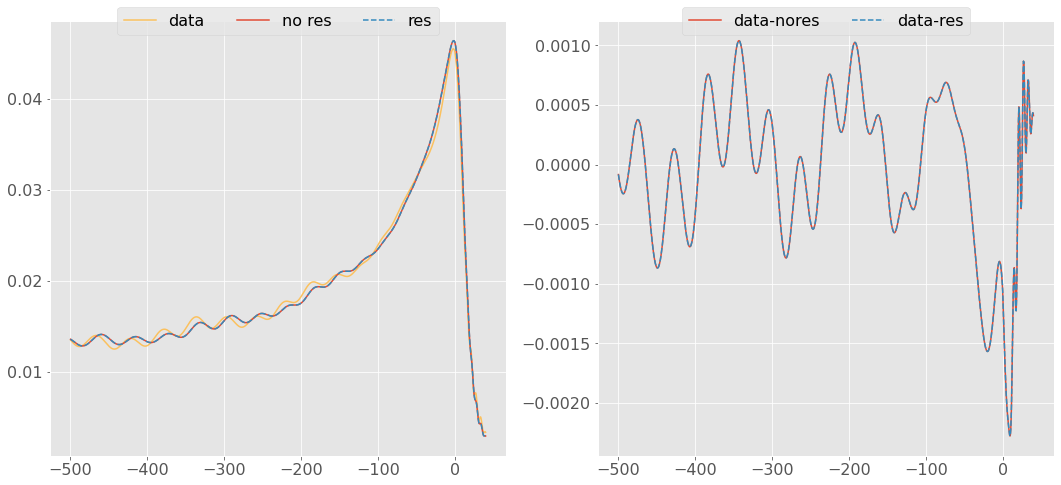

In [399]:
i=0
yhat_nores = model_nores.predict(x)[i]
yhat_res = model_res.predict(x)[i]
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(common_times, y[i], label='data', c='C4')
plt.plot(common_times, yhat_nores, label='no res', c='C0')
plt.plot(common_times, yhat_res, label='res', c='C1', ls='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)
# plt.xlim(-100, 100)

plt.subplot(1, 2, 2)
plt.plot(common_times, y[i]-yhat_nores, label='data-nores', c='C0')
plt.plot(common_times, y[i]-yhat_res, label='data-res', c='C1', ls='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
# plt.ylim(-0.01,0.01)

In [ ]:
# hmmm this doesn't seem to work when the dataset has more than one BBH system...

# try resnet with early exit and gradient stops?


In [557]:
def make_model_stop(input_shape, output_shape):
    input_layer = tf.keras.Input(shape=(input_shape,))

    x = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output1 = tf.keras.layers.Dense(output_shape, activation='linear', name='output1')(x)
    
#     stopped = tf.keras.layers.Lambda(lambda x: tf.stop_gradient(x))(output1)
#     x = tf.keras.layers.Dense(128, activation='relu')(stopped)
    
    x = tf.keras.layers.Dense(128, activation='relu')(output1)
    
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(output_shape, activation='linear')(x)
    
    # residual layer
    addition = tf.keras.layers.Add()([output1, x])
    x = tf.keras.layers.ReLU()(addition)
    output2 = tf.keras.layers.Dense(output_shape, activation='linear', name='output2')(x)
    
    
    model = tf.keras.Model(input_layer, [output1, output2])
    
    return model

In [558]:
%%time

model_2 = make_model_stop(input_shape=x.shape[1], output_shape=y.shape[1])

lr = 1e-3
# lr = None

if lr is None:
    boundaries = [1e3, 2e3]
    values = [1e-3, 1e-3/2, 1e-4]
    learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    opt = tf.keras.optimizers.Adam(learning_rate_fn)
else:
    optimizer = tf.keras.optimizers.Adam(lr)
    
model_2.compile(loss='mse', optimizer=optimizer)

callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

history_2 = model_2.fit(x, y, epochs=10000, verbose=0, callbacks=callbacks, batch_size=10)

Training:   0%|           0/10000 ETA: ?s,  ?epochs/s

CPU times: user 2min 13s, sys: 24 s, total: 2min 37s
Wall time: 51.7 s


In [607]:
history_2.history.keys()

dict_keys(['loss', 'output1_loss', 'output2_loss'])

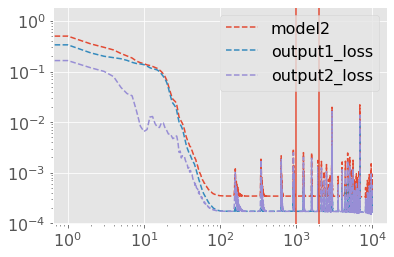

In [560]:
plt.figure()
plt.plot(history_2.history['loss'], label='model2', ls='--')

plt.plot(history_2.history['output1_loss'], label='output1_loss', ls='--')
plt.plot(history_2.history['output2_loss'], label='output2_loss', ls='--')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.axvline(1e3)
plt.axvline(2e3)

In [561]:
yhat_2[0]

array([0.0135282 , 0.01347891, 0.01342832, ..., 0.00344897, 0.0034342 ,
       0.00339539], dtype=float32)

In [562]:
yhat_2

array([[0.0135282 , 0.01347891, 0.01342832, ..., 0.00344897, 0.0034342 ,
        0.00339539]], dtype=float32)

In [563]:
model_2.predict(x)

[array([[0.2842915 , 0.28361493, 0.28252676, ..., 0.06266741, 0.06428684,
         0.06294928],
        [0.28660986, 0.2860967 , 0.2852415 , ..., 0.06247548, 0.06333907,
         0.06278071]], dtype=float32),
 array([[0.28347927, 0.28287706, 0.2818681 , ..., 0.06474027, 0.06503025,
         0.06268694],
        [0.2857341 , 0.28524476, 0.28404063, ..., 0.06405356, 0.06445694,
         0.06235029]], dtype=float32)]

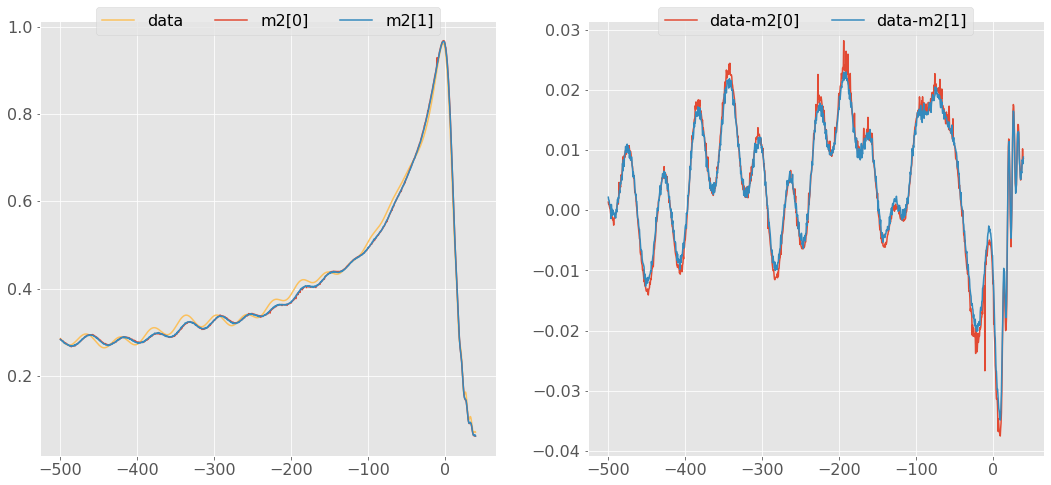

In [564]:
i=0
yhat_2_0 = model_2.predict(x)[0][i]
yhat_2_1 = model_2.predict(x)[1][i]
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(common_times, y[i], label='data', c='C4')
plt.plot(common_times, yhat_2_0, label='m2[0]', c='C0')
plt.plot(common_times, yhat_2_1, label='m2[1]', c='C1')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)
# plt.xlim(-100, 100)

plt.subplot(1, 2, 2)
plt.plot(common_times, y[i]-yhat_2_0, label='data-m2[0]', c='C0')
plt.plot(common_times, y[i]-yhat_2_1, label='data-m2[1]', c='C1')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
# plt.ylim(-0.01,0.01)

# try using the code from other notebook

In [681]:
s1s = np.linspace(0., 0.99, 10)[:,np.newaxis]

ps = [wispy.lalutils.gen_td_wf_params(m1=100., S1x=s1[0], approximant=lalsim.SEOBNRv4P, f_min=5, distance=1e6) for s1 in s1s]
times = []
amp = []
phase = []

for p in ps:
    _times, _amp, _phase = wispy.lalutils.gen_td_wf(p, t_max=40)
    times.append(_times)
    amp.append(_amp)
    phase.append(_phase)


In [682]:
# find common times and interpolate data onto common time grid
dt_M = 0.5
common_tmin = np.max(list(map(np.min, times)))
common_tmax = np.min(list(map(np.max, times)))

print(f"common_tmin = {common_tmin}")
print(f"common_tmax = {common_tmax}")

common_times = np.arange(common_tmin, common_tmax, dt_M)

ntimes = len(common_times)
print(f"ntimes = {ntimes}")

amps = np.zeros(shape=(len(m1s), ntimes))
phases = np.zeros(shape=(len(m1s), ntimes))

for i in range(len(m1s)):
    amps[i] = IUS(times[i], amp[i])(common_times)
    phases[i] = IUS(times[i], phase[i])(common_times)

common_tmin = -499.6711068477022
common_tmax = 39.714919416631346
ntimes = 1079


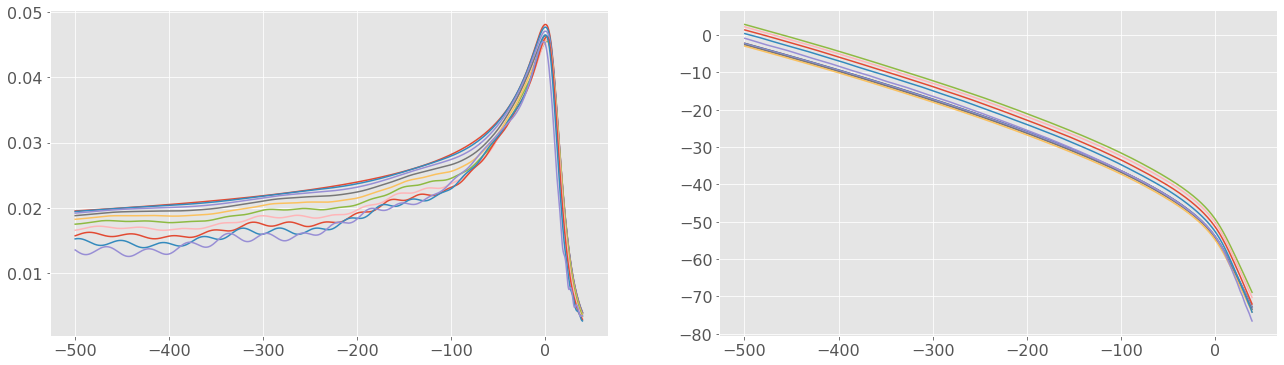

In [683]:
plt.figure(figsize=(22, 6))
plt.subplot(1, 2, 1)
for y in amps:
    plt.plot(common_times, y)
    
# plt.xlim(-100, 40)


plt.subplot(1, 2, 2)
for y in phases:
    plt.plot(common_times, y)

In [723]:
x = s1s
y = amps/amps.max()
# y = phases

# x = np.array([m1s[0], m1s[1], m1s[3], m1s[4]])
# xval = np.array([m1s[2]])

# y = np.array([_y[0], _y[1], _y[3], _y[4]])
# yval = np.array([_y[2]])

In [724]:
def build_decoder(input_shape, output_shape, units, acts, skip=False):
    # build the decoder
    input_layer = keras.Input(shape=(input_shape,))
    for i, (unit, act) in enumerate(zip(units, acts)):
        if i == 0:
            x = layers.Dense(unit, activation=act)(input_layer)
        else:
            x = layers.Dense(unit, activation=act)(x)
            
    if skip:
        x = layers.Dense(input_shape, activation='linear')(x)
        addition = tf.keras.layers.Add()([input_layer, x])
        x = tf.keras.layers.ReLU()(addition)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
            
    timeseries_output = layers.Dense(output_shape, activation="linear")(x)
    decoder_model = keras.Model(input_layer, timeseries_output)
#     print("=" * 20)
#     print("decoder summary")
#     print("=" * 20)
#     decoder_model.summary()

    return decoder_model

In [725]:
def initial_fit(model, x, y, validation_data=None, epochs=10000, batch_size=100, validation_freq=100, lr=None, sample_weight=None):
        
    loss = 'mae'
    metrics = ['mse']

    if lr == None:
        boundaries = [5000, 5100]
        values = [1e-3, 1e-4, 1e-5]
        # boundaries = [500, 600]
        # values = [1e-3, 1e-4, 1e-5]
        learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries, values)
        opt = tf.keras.optimizers.Adam(learning_rate_fn)
    else:
        opt = tf.keras.optimizers.Adam(lr)

    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    callbacks=[]
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    callbacks.append(tqdm_callback)

    history = model.fit(
        x=x,
        y=y,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0,
        batch_size=batch_size,
        validation_data=validation_data,
        validation_freq=validation_freq,
        sample_weight=sample_weight
    )

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mse'], label='mse')
    plt.yscale('log')
    plt.legend()

    if validation_data:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['val_mse'], label='val_mse')

        plt.yscale('log')
        plt.legend()
    
    return history, model

In [726]:
model = build_decoder(input_shape=x.shape[1], output_shape=y.shape[1], units = [16, 128, 512, 512], acts = ['relu', 'relu', 'relu', 'relu'])

Training:   0%|           0/100000 ETA: ?s,  ?epochs/s

CPU times: user 13min 55s, sys: 1min 38s, total: 15min 34s
Wall time: 4min 52s


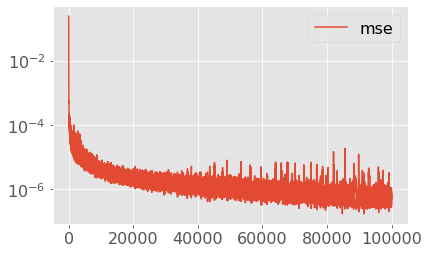

In [727]:
%%time
amp_history, model_amp = initial_fit(
    model,
    x=x,
    y=y,
    validation_data=None,
    epochs=100000,
    batch_size=20,
    validation_freq=1000,
    lr=1e-3)

In [734]:
def compare_models(model, x, y, index, times=times):
    
    yhat = model.predict(x)[index]
    
    y = y[index]
    
    plt.figure(figsize=(18, 10))
    plt.subplot(2, 1, 1)
    plt.plot(times, y, label='true')
    plt.plot(times, yhat, label='yhat', ls='--')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.xlim(-200, 20)
#     plt.ylim(0.4, 0.9)
    
    plt.subplot(2, 1, 2)
    plt.plot(times, y-yhat, label='y-yhat')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.ylim(-0.01,0.01)
    
    title = f"(approx,q)={np.around(x[index], 3)}"
    plt.suptitle(title)

In [735]:
x.shape

(10, 1)

In [736]:
y.shape

(10, 1079)

In [737]:
common_times.shape

(1079,)

In [738]:
x

array([[0.  ],
       [0.11],
       [0.22],
       [0.33],
       [0.44],
       [0.55],
       [0.66],
       [0.77],
       [0.88],
       [0.99]])

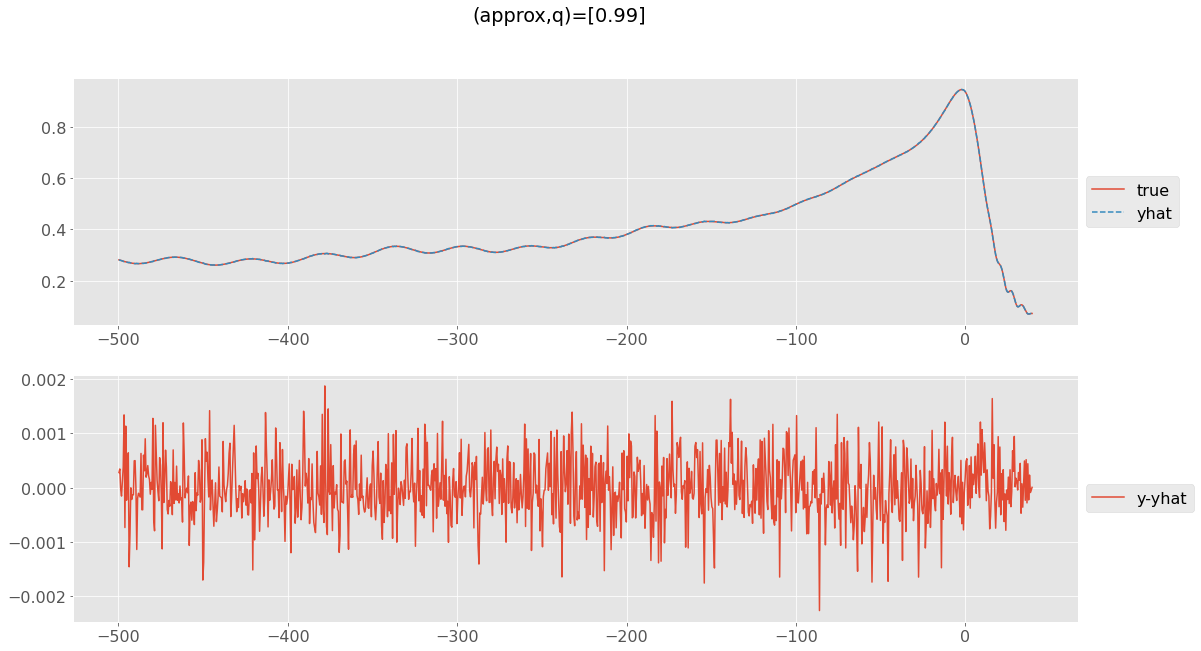

In [743]:
compare_models(model_amp, x, y, -1, common_times)

In [ ]:
# hmmmm it seems like keeping the total mass fixed and varying the spin works but varying total mass and fixed spin (high spin) does not work at all!....?